# Overview
This notebook will analyze the predictions of specific models for classification accuracy on subtypes, confusion matrix, and feature importances for the [RARE-X Challenge](https://www.synapse.org/#!Synapse:syn51198355/wiki/621435) Task 2 submissions

September 2023

Jake Albrecht


## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [2]:
import synapseclient
syn = synapseclient.login()

Welcome, Jake Albrecht!



In [3]:
def get_name(id):
    try:
        name = syn.getUserProfile(id).userName
    except synapseclient.core.exceptions.SynapseHTTPError:
        name = syn.getTeam(id).name
    return name

## Get ground truth file

In [4]:
gold  = pd.read_csv(syn.get("syn52069274").path,sep='\t')

## Get predictions, top submission from each team:

In [5]:
qu = syn.tableQuery("SELECT\
    submitterid,\
    accuracy,\
    prediction_fileid\
  FROM syn52141680\
  WHERE\
    status = 'ACCEPTED'\
    AND submission_status = 'SCORED'\
    AND accuracy IS NOT NULL\
    AND id <> 9738335\
    GROUP BY submitterid,prediction_fileid\
    ORDER BY MAX(accuracy) DESC")

In [6]:
top_soln = qu.asDataFrame().groupby('submitterid').head(1)

[WARNING] /usr/local/Caskroom/miniconda/base/envs/rare_x_post/lib/python3.11/site-packages/synapseclient/table.py:595: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(filepath,



## Score individual submissions

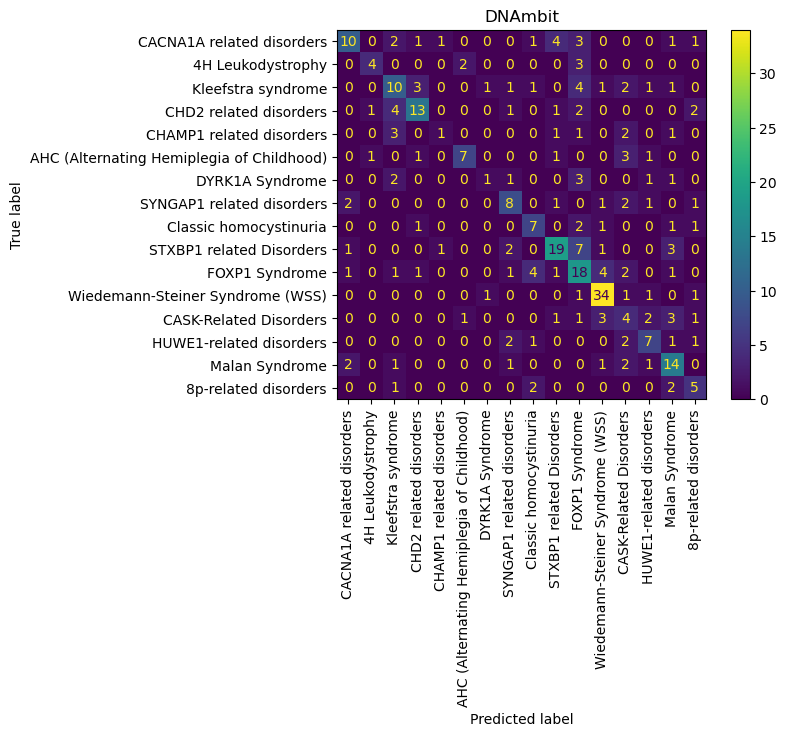

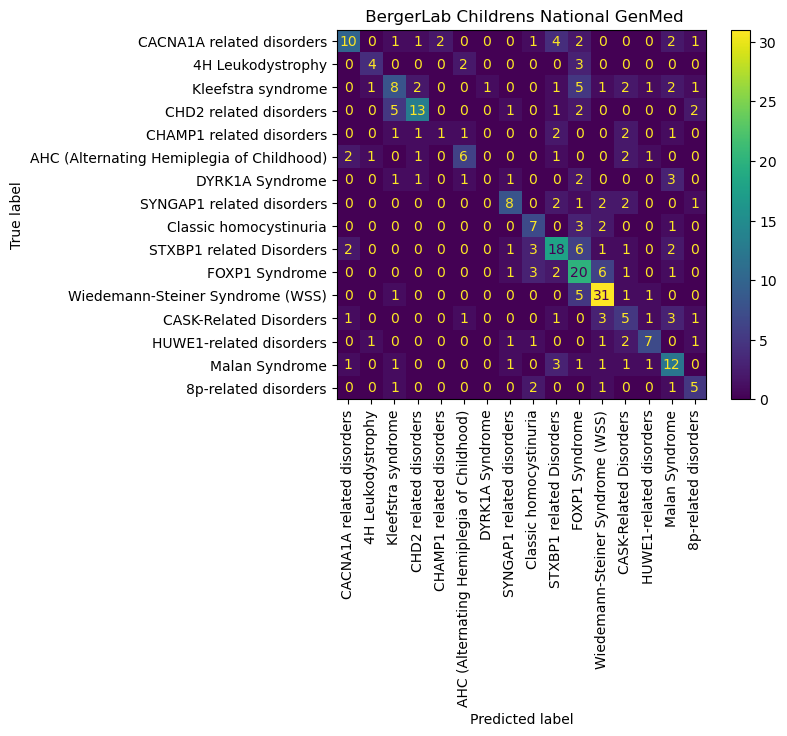

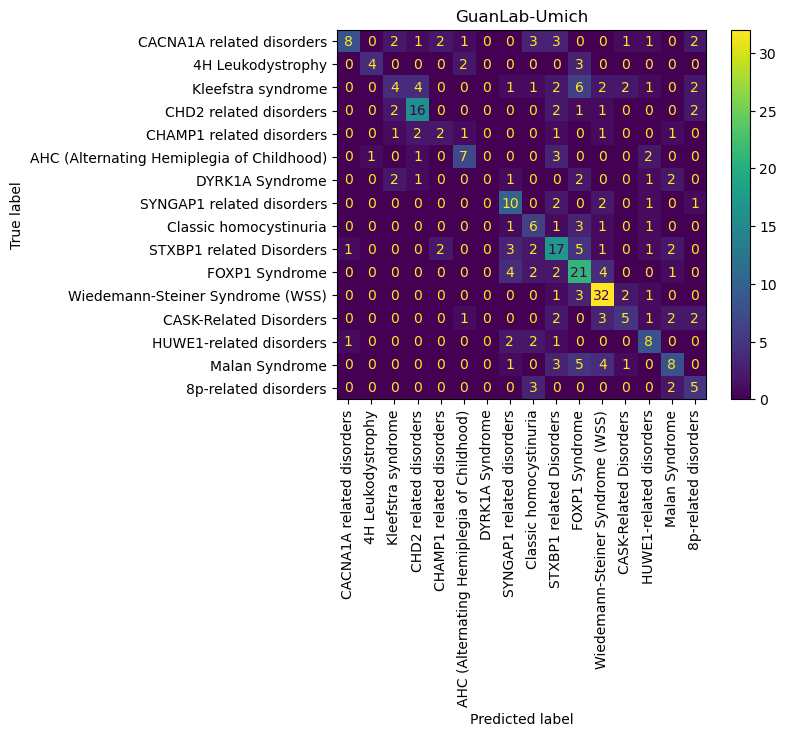

In [7]:
scores = []
for ix in range(0,3):
    teamname = get_name(top_soln.submitterid.values[ix])
    pred = pd.read_csv(syn.get(top_soln.prediction_fileid.values[ix]).path,sep='\t')
    scoresheet = pd.merge(pred,gold,on='Participant_ID',suffixes=('_pred','_gt'))
    scoresheet['Match'] = scoresheet.Disease_Name_pred == scoresheet.Disease_Name_gt
    scores.append(scoresheet.groupby('Disease_Name_gt').agg({'Match':['mean']}).rename(columns={'Match':teamname}))
    
    cm = confusion_matrix(scoresheet.Disease_Name_gt, scoresheet.Disease_Name_pred, labels=scoresheet.Disease_Name_gt.unique())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=scoresheet.Disease_Name_gt.unique())
    disp.plot()
    plt.title(teamname)
    plt.xticks(rotation=90)
    plt.savefig(f'ConfusionMatrix_{teamname}.png',bbox_inches='tight')
scores.append(scoresheet.groupby('Disease_Name_gt').agg({'Match':['count']}).rename(columns={'Match':'Cases'}))
    

In [8]:
pd.concat(scores,axis=1).to_csv('Label_accuracy.csv')